In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
df_unit_scada = pd.read_csv("PUBLIC_DVD_DISPATCH_UNIT_SCADA_202403010000.CSV")

C:\Users\alexs\AppData\Local\Temp\ipykernel_10480\3438009978.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_unit_scada = pd.read_csv("PUBLIC_DVD_DISPATCH_UNIT_SCADA_202403010000.CSV")


In [4]:
df_demand = pd.read_csv("PUBLIC_DVD_DISPATCHREGIONSUM_202403010000.CSV")

In [5]:
df_tradingprice = pd.read_csv("PUBLIC_DVD_TRADINGPRICE_202403010000.CSV")

In [6]:
df_biddayoffer = pd.read_csv("PUBLIC_DVD_BIDDAYOFFER_202403010000.CSV")

C:\Users\alexs\AppData\Local\Temp\ipykernel_10480\4199158534.py:1: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_biddayoffer = pd.read_csv("PUBLIC_DVD_BIDDAYOFFER_202403010000.CSV")


In [7]:
df_interconnectorres = pd.read_csv("PUBLIC_DVD_DISPATCHINTERCONNECTORRES_202403010000.CSV")

In [8]:
#Importing in two generator lists to capture all DUIDs
df_NEM_generators1 = pd.read_excel("NEM_rego.xlsx")
df_NEM_generators2 = pd.read_excel("NEM_rego 2.xlsx")

**Cleaning the unit_scada df**

An initial action with the unit_scada df is to asign region codes to each DUID. This will be important in furute df merges and is a requirement for energy optimisation accross regions.

In [9]:
#Setting the first row as the header as it contains the column names
df_unit_scada.columns = df_unit_scada.iloc[0]
df_unit_scada.drop(df_unit_scada.index[0], inplace=True)

In [10]:
#Removing unwanted columns
df_unit_scada.drop(df_unit_scada.columns[[0,1,2,3,7,8,9]], axis=1, inplace=True)

In [11]:
df_unit_scada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 1 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   SETTLEMENTDATE  1048574 non-null  object
 1   DUID            1048574 non-null  object
 2   SCADAVALUE      1048574 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [12]:
df_unit_scada

,SETTLEMENTDATE,DUID,SCADAVALUE
1,1/03/2024 0:05,BARCSF1,0
2,1/03/2024 0:05,BUTLERSG,8.799998
3,1/03/2024 0:05,BWTR1,4.74428
4,1/03/2024 0:05,CAPTL_WF,0
5,1/03/2024 0:05,CHALLHWF,4
...,...,...,...
1048570,1/04/2024 0:00,SHOAL1,27.424999
1048571,1/04/2024 0:00,WAUBRAWF,81.380997
1048572,1/04/2024 0:00,WOOLNTH1,-0.92
1048573,1/04/2024 0:00,YAMBUKWF,7.2


Asigning region IDs to DUIDs

In [13]:
#Dropping duplicate DUIDs from the NEM rego list
#I'm only using this list to correlate regions to the unit_scada df so I don't need the info in the duplicate rows
df_NEM_generators1.drop_duplicates(subset='DUID', keep='first', inplace=True)
df_NEM_generators2.drop_duplicates(subset='DUID', keep='first', inplace=True)

In [14]:
df_unit_scada_regions = pd.merge(df_unit_scada, df_NEM_generators1[['DUID', 'Region']], on='DUID', how='left')

In [15]:
df_unit_scada_regions = pd.merge(df_unit_scada_regions, df_NEM_generators2[['DUID', 'Region']], on='DUID', how='left')

In [16]:
df_unit_scada_regions['Region'] = df_unit_scada_regions['Region_x'].combine_first(df_unit_scada_regions['Region_y'])

In [17]:
df_unit_scada_regions

,SETTLEMENTDATE,DUID,SCADAVALUE,Region_x,Region_y,Region
0,1/03/2024 0:05,BARCSF1,0,QLD1,QLD1,QLD1
1,1/03/2024 0:05,BUTLERSG,8.799998,TAS1,TAS1,TAS1
2,1/03/2024 0:05,BWTR1,4.74428,NSW1,NSW1,NSW1
3,1/03/2024 0:05,CAPTL_WF,0,NSW1,NSW1,NSW1
4,1/03/2024 0:05,CHALLHWF,4,VIC1,NaN,VIC1
...,...,...,...,...,...,...
1048569,1/04/2024 0:00,SHOAL1,27.424999,NSW1,NaN,NSW1
1048570,1/04/2024 0:00,WAUBRAWF,81.380997,VIC1,VIC1,VIC1
1048571,1/04/2024 0:00,WOOLNTH1,-0.92,TAS1,TAS1,TAS1
1048572,1/04/2024 0:00,YAMBUKWF,7.2,VIC1,VIC1,VIC1


In [18]:
#Checking for duplicate rows
df_unit_scada_regions.duplicated().any()

False

In [19]:
#Checking to see which DUIDs are not asigned a region
df_unit_scada_regions[df_unit_scada_regions['Region'].isna()]['DUID'].value_counts()

DUID
PIONEER     8921
DG_QLD1     1744
DG_SA1      1744
DG_TAS1     1744
DG_VIC1     1744
DG_NSW1     1744
DRXQQE01    1743
DRXVQX02    1743
DRXVQX01    1743
DRXVQP01    1743
DRXVDX01    1743
DRXVDJ01    1743
DRXSQS01    1743
DRXVDP01    1743
DRXQDA01    1743
DRXNDA03    1743
DRXNQX01    1743
DRXNDA02    1743
DRXNDA01    1743
DRXNDA04    1743
DRXNDE01    1743
RT_VIC8     1742
RT_VIC7     1742
RT_TAS1     1742
RT_VIC6     1742
RT_VIC5     1742
RT_VIC4     1742
RT_VIC3     1742
RT_VIC2     1742
RT_VIC12    1742
RT_VIC11    1742
RT_VIC10    1742
RT_VIC1     1742
RT_NSW3     1742
RT_SA6      1742
RT_SA5      1742
RT_SA4      1742
RT_SA3      1742
RT_SA2      1742
RT_SA1      1742
RT_QLD1     1742
RT_NSW6     1742
RT_NSW5     1742
RT_NSW4     1742
RT_NSW2     1742
RT_NSW1     1742
RT_VIC9     1742
Name: count, dtype: int64

In [21]:
#Extracting regions from those DUIDs that contain regions. i.e. RT_VIC10 = VIC1
region_map = {}

for duid in df_unit_scada_regions[df_unit_scada_regions['egion'].isna()]['DUID']:
    if duid not in region_map:
        if 'NSW' in duid:
            region_map[duid] = 'NSW1'
        elif 'QLD' in duid:
            region_map[duid] = 'QLD1'
        elif 'VIC' in duid:
            region_map[duid] = 'VIC1'
        elif 'SA' in duid:
            region_map[duid] = 'SA1'
        elif 'TAS' in duid:
            region_map[duid] = 'TAS1'

region_map

{'DG_NSW1': 'NSW1',
 'DG_QLD1': 'QLD1',
 'DG_SA1': 'SA1',
 'DG_TAS1': 'TAS1',
 'DG_VIC1': 'VIC1',
 'RT_NSW1': 'NSW1',
 'RT_NSW2': 'NSW1',
 'RT_NSW3': 'NSW1',
 'RT_NSW4': 'NSW1',
 'RT_NSW5': 'NSW1',
 'RT_NSW6': 'NSW1',
 'RT_QLD1': 'QLD1',
 'RT_SA1': 'SA1',
 'RT_SA2': 'SA1',
 'RT_SA3': 'SA1',
 'RT_SA4': 'SA1',
 'RT_SA5': 'SA1',
 'RT_SA6': 'SA1',
 'RT_TAS1': 'TAS1',
 'RT_VIC1': 'VIC1',
 'RT_VIC10': 'VIC1',
 'RT_VIC11': 'VIC1',
 'RT_VIC12': 'VIC1',
 'RT_VIC2': 'VIC1',
 'RT_VIC3': 'VIC1',
 'RT_VIC4': 'VIC1',
 'RT_VIC5': 'VIC1',
 'RT_VIC6': 'VIC1',
 'RT_VIC7': 'VIC1',
 'RT_VIC8': 'VIC1',
 'RT_VIC9': 'VIC1'}

In [22]:
#Creating a mapped region column containing for those DUIDs missing regions
df_unit_scada_regions['Mapped_Region'] = df_unit_scada_regions['DUID'].map(region_map)
#Assigning NaN regions their appropriate region if it was in the DUID name as above
df_unit_scada_regions['Region'] = df_unit_scada_regions['Region'].fillna(df_unit_scada_regions['Mapped_Region'])

In [23]:
#These are the remaining DUIDs without a corresponding region
df_unit_scada_regions[df_unit_scada_regions['Region'].isna()]['DUID'].value_counts()

DUID
PIONEER     8921
DRXNDA01    1743
DRXNDA02    1743
DRXNDA03    1743
DRXNDA04    1743
DRXNDE01    1743
DRXNQX01    1743
DRXQDA01    1743
DRXQQE01    1743
DRXSQS01    1743
DRXVDJ01    1743
DRXVDP01    1743
DRXVDX01    1743
DRXVQP01    1743
DRXVQX01    1743
DRXVQX02    1743
Name: count, dtype: int64

In [24]:
#Renaming 'Region' column to match 'REGIONID' standard
df_unit_scada_regions.rename(columns={'Region': 'REGIONID'}, inplace=True)

In [25]:
#Altering settlement date to conform to other dfs
df_unit_scada_regions['SETTLEMENTDATE'] = pd.to_datetime(df_unit_scada_regions['SETTLEMENTDATE'], dayfirst=True)
df_unit_scada_regions['SETTLEMENTDATE'] = df_unit_scada_regions['SETTLEMENTDATE'].dt.strftime('%d/%m/%Y %H:%M:%S')
df_unit_scada_regions['SETTLEMENTDATE'] = pd.to_datetime(df_unit_scada_regions['SETTLEMENTDATE'], dayfirst=True)

In [26]:
#Dropping other columns I've deemed unnecessary
df_unit_scada_regions.drop(df_unit_scada_regions.columns[[3,4,6]], axis=1, inplace=True)

In [27]:
df_unit_scada_regions.head(100)

,SETTLEMENTDATE,DUID,SCADAVALUE,REGIONID
0,2024-03-01 00:05:00,BARCSF1,0,QLD1
1,2024-03-01 00:05:00,BUTLERSG,8.799998,TAS1
2,2024-03-01 00:05:00,BWTR1,4.74428,NSW1
3,2024-03-01 00:05:00,CAPTL_WF,0,NSW1
4,2024-03-01 00:05:00,CHALLHWF,4,VIC1
5,2024-03-01 00:05:00,CLOVER,-0.01,VIC1
6,2024-03-01 00:05:00,CLUNY,1.84802,TAS1
7,2024-03-01 00:05:00,CONDONG1,17.32,NSW1
8,2024-03-01 00:05:00,CULLRGWF,8.56,NSW1
9,2024-03-01 00:05:00,DIAPURWF1,0,VIC1


The following section asigns a binary renewable variable to the df. This is required as the future linear optimisation will rely on the renewables status of the DUID.

In [28]:
df_NEM_generators1

,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Physical Unit No.,Unit Size (MW),Aggregation,DUID,Reg Cap (MW),Max Cap (MW),Max ROC/Min
0,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generator,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,1,3.14,Y,ADPBA1G,3.14,2.428,2
2,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,1,3.14,Y,ADPBA1L,3.14,2.428,2
4,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generator,Market,Non-Scheduled,Hydro,Water,Renewable,Run of River,1-2,0.72,Y,ADPMH1,1.44,1,-
5,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generator,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,"1-4, 5-9",2.75,Y,ADPPV1,24.75,19,4
6,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generator,Market,Non-Scheduled,Solar,Solar,Renewable,Photovoltaic Flat panel,1-2,0.1,Y,ADPPV2,0.2,0.2,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,AGL Hydro Partnership,Yarrawonga Hydro Power Station,VIC1,Generator,Market,Non-Scheduled,Hydro,Water,Renewable,Hydro - Gravity,1-2,4.725,N,YWNGAHYD,9,9,0
611,RTA Yarwun Pty Ltd,Yarwun Power Station,QLD1,Generator,Market,Non-Scheduled**,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),1,154,Y,YARWUN_1,154,180,36
612,Yatpool Sun Farm Pty Ltd,Yatpool Solar Farm,VIC1,Generator,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,1-36,2.25,Y,YATSF1,94,81,16
613,Alinta Energy Retail Sales Pty Ltd,Yawong Wind Farm,VIC1,Generator,Market,Non-Scheduled,Wind,Wind,Renewable,Wind - Onshore,1-2,3.6,Y,YAWWF1,7.2,7.2,0


In [29]:
df_NEM_generators2

,Region,Asset Type,Site Name,Owner,Technology Type,Fuel Type,DUID,Number of Units,Lower Nameplate Capacity (MW),Upper Nameplate Capacity (MW),...,Dispatch Type,Full Commercial Use Date,Expected Closure Year,Closure Date,Status Bucket Summary,Fuel Bucket Summary,SurveyId,AEMO KCI Id,Survey Last Requested,Survey Version DateTime
0,NSW1,Existing Plant,133 Castlereagh St,Cogent Energy Pty Ltd,Reciprocating Engine - Compression ignition,Fossil - Natural Gas,NaN,1.0,NaN,1.00,...,NS,NaT,NaN,NaT,Existing less Announced Withdrawal,Gas other,2066.0,NaN,NaT,NaT
9,SA1,Existing Plant,Adelaide Desalination Plant,South Australian Water Corporation,Storage - Battery,Other - Other,ADPBA1G,1.0,NaN,6.27,...,S,2022-05-01,2041.0,NaT,Existing less Announced Withdrawal,Battery Storage,1844.0,NaN,2024-02-20,2024-03-18 08:58:29
10,SA1,Existing Plant,Adelaide Desalination Plant,South Australian Water Corporation,Solar PV - Fixed,Solar - Solar,ADPPV1,4.0,NaN,2.75,...,SS,2022-05-01,2041.0,NaT,Existing less Announced Withdrawal,Solar,1844.0,NaN,2024-02-20,2024-03-18 08:58:29
11,SA1,Existing Plant,Adelaide Desalination Plant,South Australian Water Corporation,Solar PV - Fixed,Solar - Solar,ADPPV2,4.0,NaN,3.43,...,NS,2022-07-01,2041.0,NaT,Existing less Announced Withdrawal,Solar,1844.0,NaN,2024-02-20,2024-03-18 08:58:29
20,SA1,Existing Plant,Angaston,Snowy Hydro Ltd,Reciprocating Engine - Compression ignition,Fossil - Diesel,ANGAST1,1.0,NaN,14.40,...,S,NaT,2070.0,NaT,Existing less Announced Withdrawal,Other,1002.0,NaN,2024-02-20,2024-03-11 16:53:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,QLD1,Existing Plant,Yarranlea Solar Farm,Yarranlea Solar Pty Ltd,Solar PV - Single axis tracking,Solar - Solar,YARANSF1,44.0,0.0,2.34,...,SS,2021-09-01,2044.0,NaT,Existing less Announced Withdrawal,Solar,1599.0,NaN,2024-02-20,2024-03-20 15:25:44
1501,QLD1,Existing Plant,Yarwun 1,RTA Yarwun Pty Ltd,Turbine - CCGT,Fossil - Natural Gas Pipeline,YARWUN_1,1.0,180.0,180.00,...,NS,NaT,NaN,NaT,Existing less Announced Withdrawal,CCGT,1257.0,NaN,2024-01-01,NaT
1503,VIC1,Existing Plant,Yatpool Solar Farm,Yatpool Sun Farm Pty Ltd,Solar PV - Single axis tracking,Solar - Solar,YATSF1,16.0,NaN,2.75,...,SS,NaT,2050.0,NaT,Existing less Announced Withdrawal,Solar,1423.0,NaN,2024-02-20,2024-02-26 09:33:42
1505,VIC1,Existing Plant,Yawong Wind Farm,Yawong Wind Farm Pty Ltd,Wind Turbine - Onshore,Wind - Wind,YAWWF1,2.0,3.6,3.60,...,NS,2018-12-01,2048.0,NaT,Existing less Announced Withdrawal,Wind,1495.0,NaN,2022-09-01,2022-09-30 00:17:41


In [30]:
print(df_NEM_generators1['Fuel Source - Primary'].unique())
print(df_NEM_generators2['Fuel Type'].unique())

['Battery storage' 'Hydro' 'Solar' 'Renewable/ Biomass / Waste' 'Fossil'
 'Wind' '-' nan ' ']
['Fossil - Natural Gas' 'Other - Other' 'Solar - Solar' 'Fossil - Diesel'
 'Fossil - Waste Coal Mine Gas' 'Wind - Wind'
 'Fossil - Natural Gas Pipeline' 'Hydro - Water' 'Fossil - Black Coal'
 'Fossil - Coal Seam Methane' 'Renewable Biomass or Waste - Biomass'
 'Renewable Biomass or Waste - Landfill Gas'
 'Renewable Biomass or Waste - Bagasse' 'Fossil - Brown Coal'
 'Renewable Biomass or Waste - Wood Waste']


In [31]:
#Asigning renewables status to generators from NEM generator df 1
gen_1_fuel_source = []
for fuel in df_NEM_generators1['Fuel Source - Primary']:
    if fuel in ['Battery storage','Hydro','Solar','Renewable/ Biomass / Waste','Wind']:
        gen_1_fuel_source.append(1)
    elif fuel == 'Fossil':
        gen_1_fuel_source.append(0)
    else:
        gen_1_fuel_source.append('unknown')

df_NEM_generators1['renewables_y/n'] = gen_1_fuel_source

In [32]:
#Asigning renewables status to generators from NEM generator df 2
gen_2_fuel_source = []
for fuel in df_NEM_generators2['Fuel Type']:
    if fuel in ['Solar - Solar','Wind - Wind','Hydro - Water','Renewable Biomass or Waste - Biomass',
                'Renewable Biomass or Waste - Landfill Gas','Renewable Biomass or Waste - Bagasse',
                'Renewable Biomass or Waste - Wood Waste']:
        gen_2_fuel_source.append(1)
    elif fuel in ['Fossil - Natural Gas', 'Fossil - Diesel','Fossil - Waste Coal Mine Gas',
                  'Fossil - Natural Gas Pipeline','Fossil - Black Coal','Fossil - Coal Seam Methane',
                  'Fossil - Brown Coal']:
        gen_2_fuel_source.append(0)
    else:
        gen_2_fuel_source.append('unknown')

df_NEM_generators2['renewables_y/n'] = gen_2_fuel_source

In [33]:
#Merging the generator dfs with the unit scada df to incorporate the renewables_y/n variable
merged_df = pd.merge(df_unit_scada_regions, df_NEM_generators1[['DUID','renewables_y/n']], on='DUID', how='left', suffixes=('', '_gen1'))
merged_df = pd.merge(merged_df, df_NEM_generators2[['DUID','renewables_y/n']], on='DUID', how='left', suffixes=('', '_gen2'))
merged_df['renewables_y/n'] = merged_df['renewables_y/n'].fillna(merged_df['renewables_y/n_gen2'])

#Assesing how many rows have a missing renewables value and setting those with unknown renewable status as 'unknown'
print(merged_df['renewables_y/n'].isna().sum())
merged_df['renewables_y/n'].fillna('unknown', inplace=True)
df_unit_scada_regions['renewables_y/n'] = merged_df['renewables_y/n']

89078


In [34]:
# Those DUIDs with unknown renewables status
df_unit_scada_regions[df_unit_scada_regions['renewables_y/n'] == 'unknown']['DUID'].unique()

array(['PIONEER', 'BALBL1', 'CBWWBA1L', 'DALNTHL1', 'DG_NSW1', 'DG_QLD1',
       'DG_SA1', 'DG_TAS1', 'DG_VIC1', 'DRXNDA01', 'DRXNDA02', 'DRXNDA03',
       'DRXNDA04', 'DRXNDE01', 'DRXNQX01', 'DRXQDA01', 'DRXQQE01',
       'DRXSQS01', 'DRXVDJ01', 'DRXVDP01', 'DRXVDX01', 'DRXVQP01',
       'DRXVQX01', 'DRXVQX02', 'GANNBL1', 'HPRL1', 'LBBL1', 'PUMP1',
       'PUMP2', 'RT_NSW1', 'RT_NSW2', 'RT_NSW3', 'RT_NSW4', 'RT_NSW5',
       'RT_NSW6', 'RT_QLD1', 'RT_SA1', 'RT_SA2', 'RT_SA3', 'RT_SA4',
       'RT_SA5', 'RT_SA6', 'RT_TAS1', 'RT_VIC1', 'RT_VIC10', 'RT_VIC11',
       'RT_VIC12', 'RT_VIC2', 'RT_VIC3', 'RT_VIC4', 'RT_VIC5', 'RT_VIC6',
       'RT_VIC7', 'RT_VIC8', 'RT_VIC9', 'SHPUMP', 'VBBL1', 'WALGRVL1',
       'WANDBL1'], dtype=object)

Utilising the NEM generator dfs to asign a unit size for each duid. The future optimisation will rely on the max energy production of certain DUIDS.

In [35]:
df_unit_scada_regions = pd.merge(df_unit_scada_regions, df_NEM_generators1[['DUID', 'Unit Size (MW)']], on='DUID', how='left')
df_unit_scada_regions = pd.merge(df_unit_scada_regions, df_NEM_generators2[['DUID', 'Upper Nameplate Capacity (MW)']], on='DUID', how='left')

In [36]:
#Using the 'Unit Size (MW)' metric from the first NEM_generators df as a default, some missing values are filled by the
# 'Upper Nameplate Capacity (MW)' metric of the second NEM generators df
print(df_unit_scada_regions['Unit Size (MW)'].isna().sum())
df_unit_scada_regions['Unit Size (MW)'] = df_unit_scada_regions['Unit Size (MW)'].fillna(df_unit_scada_regions['Upper Nameplate Capacity (MW)'])
print(df_unit_scada_regions['Unit Size (MW)'].isna().sum())

104975
89078


In [37]:
df_unit_scada_regions.drop('Upper Nameplate Capacity (MW)', axis=1, inplace=True)

In [38]:
df_unit_scada_regions.head(100)

,SETTLEMENTDATE,DUID,SCADAVALUE,REGIONID,renewables_y/n,Unit Size (MW)
0,2024-03-01 00:05:00,BARCSF1,0,QLD1,1,10
1,2024-03-01 00:05:00,BUTLERSG,8.799998,TAS1,1,14.4
2,2024-03-01 00:05:00,BWTR1,4.74428,NSW1,1,30
3,2024-03-01 00:05:00,CAPTL_WF,0,NSW1,1,2
4,2024-03-01 00:05:00,CHALLHWF,4,VIC1,1,1.5
5,2024-03-01 00:05:00,CLOVER,-0.01,VIC1,1,14.5
6,2024-03-01 00:05:00,CLUNY,1.84802,TAS1,1,19
7,2024-03-01 00:05:00,CONDONG1,17.32,NSW1,1,30
8,2024-03-01 00:05:00,CULLRGWF,8.56,NSW1,1,2
9,2024-03-01 00:05:00,DIAPURWF1,0,VIC1,1,3.5


In [39]:
#Setting unknown Unit Sizes to corresponding SCADAVALUES
df_unit_scada_regions['Unit Size (MW)'].fillna(df_unit_scada_regions['SCADAVALUE'], inplace=True)

In [40]:
#Ensureing all SCADAVALUEs are floats
df_unit_scada_regions["SCADAVALUE"] = pd.to_numeric(df_unit_scada_regions["SCADAVALUE"])

In [41]:
#Converting any string unit sizes to numeric
#Initially handling some strings of form "0.64, 0.58", for example
def convert_to_numeric(value):
    # Check if the value is a string and contains a comma
    if isinstance(value, str) and ',' in value:
        # Split the string by the comma and take the first element
        return float(value.split(',')[0].strip())
    else:
        # Otherwise, convert the value to a float
        return float(value)
    
df_unit_scada_regions["Unit Size (MW)"] = df_unit_scada_regions['Unit Size (MW)'].apply(convert_to_numeric)

In [42]:
#Ensuring max unit powers are no less than scada values
UnitSize = []

for index, row in df_unit_scada_regions.iterrows():
    if row['Unit Size (MW)'] < row['SCADAVALUE']:
        UnitSize.append(row['SCADAVALUE'])
    else:
        UnitSize.append(row['Unit Size (MW)'])
        
df_unit_scada_regions['Unit Size (MW)'] = UnitSize

In [43]:
#Creating MaxPower(MW) Variable
MaxPower = []

for index, row in df_unit_scada_regions.iterrows():
    if row['renewables_y/n'] == 1:
        MaxPower.append(row['SCADAVALUE'])
    else:
        MaxPower.append(row['Unit Size (MW)'])

df_unit_scada_regions['MaxPower'] = MaxPower

In [44]:
df_unit_scada.head(100)

,SETTLEMENTDATE,DUID,SCADAVALUE
1,1/03/2024 0:05,BARCSF1,0
2,1/03/2024 0:05,BUTLERSG,8.799998
3,1/03/2024 0:05,BWTR1,4.74428
4,1/03/2024 0:05,CAPTL_WF,0
5,1/03/2024 0:05,CHALLHWF,4
6,1/03/2024 0:05,CLOVER,-0.01
7,1/03/2024 0:05,CLUNY,1.84802
8,1/03/2024 0:05,CONDONG1,17.32
9,1/03/2024 0:05,CULLRGWF,8.56
10,1/03/2024 0:05,DIAPURWF1,0


**Cleaning the tradingprice df**

In [45]:
df_tradingprice = df_tradingprice[['SETTLEMENTDATE','REGIONID','RRP']]

In [46]:
df_tradingprice.head(100)

,SETTLEMENTDATE,REGIONID,RRP
0,1/03/2024 6:10,NSW1,137.41
1,1/03/2024 6:10,VIC1,135.01
2,1/03/2024 6:10,SA1,138.74
3,1/03/2024 6:10,QLD1,143.55
4,1/03/2024 6:10,TAS1,126.22
5,1/03/2024 7:05,NSW1,100.01
6,1/03/2024 7:05,VIC1,103.57
7,1/03/2024 7:05,SA1,106.95
8,1/03/2024 7:05,QLD1,98.40
9,1/03/2024 7:05,TAS1,100.20


In [47]:
df_tradingprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44641 entries, 0 to 44640
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SETTLEMENTDATE  44640 non-null  object 
 1   REGIONID        44640 non-null  object 
 2   RRP             44640 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.0+ MB


**Cleaning the demand dataset**

In [48]:
df_demand = df_demand[["SETTLEMENTDATE", 'REGIONID', 'TOTALDEMAND', 'AVAILABLEGENERATION', 'DEMANDFORECAST']]

In [49]:
df_demand.head()

,SETTLEMENTDATE,REGIONID,TOTALDEMAND,AVAILABLEGENERATION,DEMANDFORECAST
0,1/03/2024 6:10,NSW1,8430.63,12460.98617,43.0
1,1/03/2024 6:10,QLD1,6614.33,9905.23714,27.0
2,1/03/2024 6:10,SA1,1420.18,2606.33162,14.0
3,1/03/2024 6:10,TAS1,1264.70,2160.72233,9.0
4,1/03/2024 6:10,VIC1,5262.39,8430.14741,50.0


In [50]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44641 entries, 0 to 44640
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SETTLEMENTDATE       44640 non-null  object 
 1   REGIONID             44640 non-null  object 
 2   TOTALDEMAND          44640 non-null  float64
 3   AVAILABLEGENERATION  44640 non-null  float64
 4   DEMANDFORECAST       44640 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.7+ MB


**Cleaning the interconnector dataset**

In [51]:
df_interconnectorres = df_interconnectorres[['SETTLEMENTDATE','INTERCONNECTORID',
                                             "MWFLOW",'EXPORTLIMIT','IMPORTLIMIT','MARGINALVALUE']]

In [52]:
df_interconnectorres.head(100)

,SETTLEMENTDATE,INTERCONNECTORID,MWFLOW,EXPORTLIMIT,IMPORTLIMIT,MARGINALVALUE
0,1/03/2024 0:05,N-Q-MNSP1,-9.00000,49.32741,-88.30000,0.0
1,1/03/2024 0:05,NSW1-QLD1,22.94767,468.18412,-1106.75313,0.0
2,1/03/2024 0:05,T-V-MNSP1,-443.00000,-237.70001,-442.99871,0.0
3,1/03/2024 0:05,V-S-MNSP1,45.00000,125.00000,-35.00000,0.0
4,1/03/2024 0:05,V-SA,70.06060,310.91596,-474.61365,0.0
5,1/03/2024 0:05,VIC1-NSW1,-309.24339,629.37621,-640.85588,0.0
6,1/03/2024 0:10,N-Q-MNSP1,-9.00000,47.02741,-90.60000,0.0
7,1/03/2024 0:10,NSW1-QLD1,-29.76748,465.14026,-1106.55983,0.0
8,1/03/2024 0:10,T-V-MNSP1,-409.40497,-210.80002,-409.40671,0.0
9,1/03/2024 0:10,V-S-MNSP1,45.00000,125.00000,-35.00000,0.0


In [53]:
df_interconnectorres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53569 entries, 0 to 53568
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SETTLEMENTDATE    53568 non-null  object 
 1   INTERCONNECTORID  53568 non-null  object 
 2   MWFLOW            53568 non-null  float64
 3   EXPORTLIMIT       53568 non-null  float64
 4   IMPORTLIMIT       53568 non-null  float64
 5   MARGINALVALUE     53568 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.5+ MB


In [54]:
#Converting settlementdate string to datetime object
df_interconnectorres['SETTLEMENTDATE'] = pd.to_datetime(df_interconnectorres['SETTLEMENTDATE'], dayfirst=True)

In [55]:
# List of regions
regions = ['NSW1', 'QLD1', 'VIC1', 'SA1', 'TAS1']

# Repeat the list to cover the length of the df
# np.tile repeats the list to make it the length of the df
repeated_regions = np.tile(regions, len(df_interconnectorres) // len(regions) + 1)[:len(df_interconnectorres)]

df_interconnectorres['REGIONID'] = repeated_regions

After researching what each interconnectorID indicates, I made efforts to asign energy export and import limits to each region at each time point.

In [56]:
# A function for setting the export and import limits for given region dependent on the limits of each interconnector
def update_limits(df):
    unique_dates = df['SETTLEMENTDATE'].unique()

    for date in unique_dates:
        # Filter the DataFrame for the current date
        df_date = df[df['SETTLEMENTDATE'] == date]

        # Calculate new values based on the interconnectors
        nsw1_importlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'N-Q-MNSP1', 'EXPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'NSW1-QLD1', 'EXPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'VIC1-NSW1', 'EXPORTLIMIT'].sum())

        nsw1_exportlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'NSW1-QLD1', 'IMPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'VIC1-NSW1', 'IMPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'VIC1-NSW1', 'IMPORTLIMIT'].sum())

        qld1_importlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'N-Q-MNSP1', 'IMPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'NSW1-QLD1', 'IMPORTLIMIT'].sum())

        qld1_exportlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'N-Q-MNSP1', 'EXPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'NSW1-QLD1', 'EXPORTLIMIT'].sum())

        vic1_importlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'VIC1-NSW1', 'IMPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'V-S-MNSP1', 'IMPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'V-SA', 'IMPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'T-V-MNSP1', 'EXPORTLIMIT'].sum())

        vic1_exportlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'VIC1-NSW1', 'EXPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'V-S-MNSP1', 'EXPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'V-SA', 'EXPORTLIMIT'].sum() +
                            df_date.loc[df_date['INTERCONNECTORID'] == 'T-V-MNSP1', 'IMPORTLIMIT'].sum())

        sa1_importlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'V-S-MNSP1', 'EXPORTLIMIT'].sum() +
                           df_date.loc[df_date['INTERCONNECTORID'] == 'V-SA', 'EXPORTLIMIT'].sum())

        sa1_exportlimit = (df_date.loc[df_date['INTERCONNECTORID'] == 'V-S-MNSP1', 'IMPORTLIMIT'].sum() +
                           df_date.loc[df_date['INTERCONNECTORID'] == 'V-SA', 'IMPORTLIMIT'].sum())

        tas1_importlimit = df_date.loc[df_date['INTERCONNECTORID'] == 'T-V-MNSP1', 'IMPORTLIMIT'].sum()

        tas1_exportlimit = df_date.loc[df_date['INTERCONNECTORID'] == 'T-V-MNSP1', 'EXPORTLIMIT'].sum()

        # Assign new values to the original DataFrame
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'NSW1'), 'IMPORTLIMIT'] = nsw1_importlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'NSW1'), 'EXPORTLIMIT'] = nsw1_exportlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'QLD1'), 'IMPORTLIMIT'] = qld1_importlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'QLD1'), 'EXPORTLIMIT'] = qld1_exportlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'VIC1'), 'IMPORTLIMIT'] = vic1_importlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'VIC1'), 'EXPORTLIMIT'] = vic1_exportlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'SA1'), 'IMPORTLIMIT'] = sa1_importlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'SA1'), 'EXPORTLIMIT'] = sa1_exportlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'TAS1'), 'IMPORTLIMIT'] = tas1_importlimit
        df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'TAS1'), 'EXPORTLIMIT'] = tas1_exportlimit

    return df

# Apply the function to update the limits
df_interconnectorres_updated = update_limits(df_interconnectorres)

In [57]:
#The above function takes a long time so I had a crack at implementing vectorised functions to speed it up.
#There's a bug in here somewhere unfortunately.
#Leaving it here for future fixing.

# def compute_region_limits(df):
#     # Compute the sums needed for each INTERCONNECTORID
#     export_sums = df.groupby(['SETTLEMENTDATE', 'INTERCONNECTORID'])['EXPORTLIMIT'].sum().unstack(fill_value=0)
#     import_sums = df.groupby(['SETTLEMENTDATE', 'INTERCONNECTORID'])['IMPORTLIMIT'].sum().unstack(fill_value=0)

#     # Initialize the new columns
#     df['NEW_EXPORTLIMIT'] = 0.0
#     df['NEW_IMPORTLIMIT'] = 0.0

#     for date in df['SETTLEMENTDATE'].unique():
#         # Get the sums for the current date
#         export_sum = export_sums.loc[date]
#         import_sum = import_sums.loc[date]

#         # Calculate the new limits for each region
#         nsw1_importlimit = export_sum.get('N-Q-MNSP1', 0) + export_sum.get('NSW1-QLD1', 0) + export_sum.get('VIC1-NSW1', 0)
#         nsw1_exportlimit = import_sum.get('N-Q-MNSP1', 0) + import_sum.get('NSW1-QLD1', 0) + import_sum.get('VIC1-NSW1', 0)
#         qld1_importlimit = export_sum.get('N-Q-MNSP1', 0) + import_sum.get('NSW1-QLD1', 0)
#         qld1_exportlimit = export_sum.get('N-Q-MNSP1', 0) + export_sum.get('NSW1-QLD1', 0)
#         vic1_importlimit = import_sum.get('VIC1-NSW1', 0) + import_sum.get('V-S-MNSP1', 0) + import_sum.get('V-SA', 0) + export_sum.get('T-V-MNSP1', 0)
#         vic1_exportlimit = export_sum.get('VIC1-NSW1', 0) + export_sum.get('V-S-MNSP1', 0) + export_sum.get('V-SA', 0) + import_sum.get('T-V-MNSP1', 0)
#         sa1_importlimit = export_sum.get('V-S-MNSP1', 0) + export_sum.get('V-SA', 0)
#         sa1_exportlimit = import_sum.get('V-S-MNSP1', 0) + import_sum.get('V-SA', 0)
#         tas1_importlimit = import_sum.get('T-V-MNSP1', 0)
#         tas1_exportlimit = export_sum.get('T-V-MNSP1', 0)

#         # Update the DataFrame
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'NSW1'), 'NEW_IMPORTLIMIT'] = nsw1_importlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'NSW1'), 'NEW_EXPORTLIMIT'] = nsw1_exportlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'QLD1'), 'NEW_IMPORTLIMIT'] = qld1_importlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'QLD1'), 'NEW_EXPORTLIMIT'] = qld1_exportlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'VIC1'), 'NEW_IMPORTLIMIT'] = vic1_importlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'VIC1'), 'NEW_EXPORTLIMIT'] = vic1_exportlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'SA1'), 'NEW_IMPORTLIMIT'] = sa1_importlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'SA1'), 'NEW_EXPORTLIMIT'] = sa1_exportlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'TAS1'), 'NEW_IMPORTLIMIT'] = tas1_importlimit
#         df.loc[(df['SETTLEMENTDATE'] == date) & (df['REGIONID'] == 'TAS1'), 'NEW_EXPORTLIMIT'] = tas1_exportlimit

#     return df

# # Apply the function to update the limits
# df_interconnectorres_updated = compute_region_limits(df_interconnectorres)

In [58]:
df_interconnectorres_updated.drop(['MWFLOW', 'MARGINALVALUE', 'INTERCONNECTORID'], axis=1, inplace=True)

In [59]:
df_interconnectorres_updated.drop_duplicates(inplace=True)

In [60]:
df_interconnectorres.head(100)

,SETTLEMENTDATE,EXPORTLIMIT,IMPORTLIMIT,REGIONID
0,2024-03-01 00:05:00,-2388.46489,1146.88774,NSW1
1,2024-03-01 00:05:00,517.51153,-1195.05313,QLD1
2,2024-03-01 00:05:00,622.29346,-1388.16954,VIC1
3,2024-03-01 00:05:00,-509.61365,435.91596,SA1
4,2024-03-01 00:05:00,-237.70001,-442.99871,TAS1
6,2024-03-01 00:10:00,512.16767,-1197.15983,QLD1
7,2024-03-01 00:10:00,640.93608,-1365.04664,VIC1
8,2024-03-01 00:10:00,-515.39430,436.69688,SA1
9,2024-03-01 00:10:00,-210.80002,-409.40671,TAS1
10,2024-03-01 00:10:00,-2384.26447,1125.81358,NSW1


**The below are some redundant features that didn't make it into the model**

In [62]:
# interconnector_region_map = {'N-Q-MNSP1':'QLD1',
#                              'NSW1-QLD1':'QLD1',
#                              'T-V-MNSP1':'TAS1',
#                              'V-S-MNSP1': 'VIC1',
#                              'V-SA':'VIC1',
#                              'VIC1-NSW1':'VIC1'}

# df_interconnectorres['REGIONID'] = df_interconnectorres['INTERCONNECTORID'].map(interconnector_region_map)

In [63]:
# df_interconnectorres = df_interconnectorres.groupby(['SETTLEMENTDATE', 'REGIONID']).agg({
#     'EXPORTLIMIT': 'sum',  
#     'IMPORTLIMIT': 'sum', 
#     'MWFLOW': 'sum',     
#     'MARGINALVALUE': 'sum' 
# }).reset_index()

Cleaning the biddayoffer dataset

In [64]:
#df_biddayoffer = df_biddayoffer[['DUID', 'OFFERDATE','PRICEBAND1','PRICEBAND2','PRICEBAND3','PRICEBAND4','PRICEBAND5',
#               'PRICEBAND6','PRICEBAND7','PRICEBAND8','PRICEBAND9','PRICEBAND10']]

In [65]:
#df_biddayoffer.head(100)

In [66]:
#df_biddayoffer.info()

In [67]:
#Converting settlementdate string to datetime object
#df_biddayoffer['OFFERDATE'] = pd.to_datetime(df_biddayoffer['OFFERDATE'], dayfirst=True)

In [68]:
#Changing offer date to settlement date for the purposes of this exercise
#df_biddayoffer.rename(columns={'OFFERDATE' :'SETTLEMENTDATE'}, inplace=True)

In [69]:
#Also rounding dates up for the purpose of the exercise
# df_biddayoffer['SETTLEMENTDATE'] = df_biddayoffer['SETTLEMENTDATE'].dt.ceil('10T')

In [70]:
# df_biddayoffer.drop_duplicates(inplace=True)

**Merging datasets**

In [71]:
df = pd.merge(df_demand, df_tradingprice, on=['SETTLEMENTDATE','REGIONID'], how='inner')

In [72]:
#Converting SETTLEMENTDATE to datetime object
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'], dayfirst=True)

In [73]:
#Merging in the units_scada_regions df
df = pd.merge(df, df_unit_scada_regions, on=['SETTLEMENTDATE','REGIONID'], how='inner')

In [74]:
#Merging intercontector df
df = pd.merge(df, df_interconnectorres_updated, on=['SETTLEMENTDATE','REGIONID'], how='inner')

In [75]:
df.head(100)

,SETTLEMENTDATE,REGIONID,TOTALDEMAND,AVAILABLEGENERATION,DEMANDFORECAST,RRP,DUID,SCADAVALUE,renewables_y/n,Unit Size (MW),MaxPower,EXPORTLIMIT,IMPORTLIMIT
0,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,BWTR1,4.401320,1,30.000000,4.401320,-2299.28739,1364.63307
1,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,CAPTL_WF,37.027908,1,37.027908,37.027908,-2299.28739,1364.63307
2,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,CONDONG1,26.040001,1,30.000000,26.040001,-2299.28739,1364.63307
3,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,CULLRGWF,6.660000,1,6.660000,6.660000,-2299.28739,1364.63307
4,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,ERGT01,0.000000,0,41.500000,41.500000,-2299.28739,1364.63307
5,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,GB01,0.000000,0,25.000000,25.000000,-2299.28739,1364.63307
6,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,GRIFSF1,0.001526,1,2.270000,0.001526,-2299.28739,1364.63307
7,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,MLSP1,0.037000,1,12.000000,0.037000,-2299.28739,1364.63307
8,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,ROYALLA1,0.000000,1,1.000000,0.000000,-2299.28739,1364.63307
9,2024-03-01 06:10:00,NSW1,8430.63,12460.98617,43.0,137.41,SHOAL1,32.224998,0,32.224998,32.224998,-2299.28739,1364.63307


In [76]:
#Converting the renewables column to numeric for subsequent modelling
#Any 'unknown' types will be reverted to 0 (non-renewable)
df['renewables_y/n'] = pd.to_numeric(df['renewables_y/n'], errors='coerce').fillna(0)

In [77]:
#Dropping unnecessary columns
df.drop(['AVAILABLEGENERATION', 'DEMANDFORECAST', 'SCADAVALUE', 'Unit Size (MW)'], axis=1, inplace=True)

In [78]:
#Grouping the df by settlement date, region and renewables status
df = df.groupby(['SETTLEMENTDATE', 'REGIONID', 'renewables_y/n']).agg({
    'EXPORTLIMIT': 'mean', #These variables are are repeated within the same timepoint and region in the df
    'IMPORTLIMIT': 'mean', #Thus the mean captures the appropriate value.
    'TOTALDEMAND': 'mean',    
    'RRP': 'mean',  
    'MaxPower': 'sum',
    'DUID': 'sum' #The DUIDs variable is redundant in the model hence summing it
}).reset_index()

In [79]:
df.head(100)

,SETTLEMENTDATE,REGIONID,renewables_y/n,EXPORTLIMIT,IMPORTLIMIT,TOTALDEMAND,RRP,MaxPower,DUID
0,2024-03-01 00:05:00,NSW1,0.0,-2388.46489,1146.88774,8174.29,88.89,10677.461180,ERGT01GB01SHOAL1BW01BW02BW03BW04CG1CG2CG3CG4DG...
1,2024-03-01 00:05:00,NSW1,1.0,-2388.46489,1146.88774,8174.29,88.89,1161.164666,BWTR1CAPTL_WFCONDONG1CULLRGWFGRIFSF1MLSP1ROYAL...
2,2024-03-01 00:05:00,QLD1,0.0,517.51153,-1195.05313,6668.18,92.13,11678.890823,MBAHNTHBARCALDNBRAEMAR1BRAEMAR2BRAEMAR3BRAEMAR...
3,2024-03-01 00:05:00,QLD1,1.0,517.51153,-1195.05313,6668.18,92.13,555.606371,BARCSF1HUGSF1KEPBG1LRSF1RPCGBARRON-1BARRON-2BB...
4,2024-03-01 00:05:00,SA1,0.0,-509.61365,435.91596,1458.24,93.12,2067.992130,BARKIPS1BOLIVPS1CBWWBA1LDALNTHL1DG_SA1DRYCGT1D...
5,2024-03-01 00:05:00,SA1,1.0,-509.61365,435.91596,1458.24,93.12,735.882620,BLUFF1BNGSF1BNGSF2BOWWBA1GBOWWBA1LBOWWPV1CATHR...
6,2024-03-01 00:05:00,TAS1,0.0,-237.70001,-442.99871,1091.74,98.27,303.600000,BBTHREE1BBTHREE2BBTHREE3DG_TAS1RT_TAS1TVCC201T...
7,2024-03-01 00:05:00,TAS1,1.0,-237.70001,-442.99871,1091.74,98.27,687.642105,BUTLERSGCLUNYPALOONAREPULSEROWALLANWOOLNTH1BAS...
8,2024-03-01 00:05:00,VIC1,0.0,622.29346,-1388.16954,4626.79,90.10,7087.234890,BALBL1BDL01BDL02DG_VIC1GANNBL1JLA01JLA02JLA03J...
9,2024-03-01 00:05:00,VIC1,1.0,622.29346,-1388.16954,4626.79,90.10,522.433970,CHALLHWFCLOVERDIAPURWF1MLWF1PORTWFRUBICONWAUBR...


**The Linear Model**
In creating a model, I decided on an arbitrary objective that may not replicate the actual energy market but uses the real market data to depict how a carbon tax may influence energy supply and pricing. To enable this, DUIDs (generators) were earlier classified as renewable or non-renewable. In the model, any electricity being produced by non-renewable sources was priced at RRP*1.01, whereas renewable sources were simply priced at RRP. Regions could export and import between themselves according to the real world limits.

In [80]:
import pulp

I first built the model on a single timepoint for simplicity

In [81]:
# Filter for one settlement date
df_unique_date = df[df['SETTLEMENTDATE'] == '2024-03-01 00:05:00']

# Create the problem
prob = pulp.LpProblem("Minimize_Price", pulp.LpMinimize)

# Decision variables for renewable and non-renewable generation
gen_renewable = pulp.LpVariable.dicts("GenRenewable", df_unique_date['REGIONID'].unique(), lowBound=0)
gen_non_renewable = pulp.LpVariable.dicts("GenNonRenewable", df_unique_date['REGIONID'].unique(), lowBound=0)

# Decision variables for export and import
exports = pulp.LpVariable.dicts("Export", df_unique_date['REGIONID'].unique(), lowBound=0)
imports = pulp.LpVariable.dicts("Import", df_unique_date['REGIONID'].unique(), lowBound=0)

# Objective function
prob += pulp.lpSum([
    df_unique_date.loc[df_unique_date['REGIONID'] == region, 'RRP'].values[0] * gen_renewable[region] +
    df_unique_date.loc[df_unique_date['REGIONID'] == region, 'RRP'].values[0] * gen_non_renewable[region] * 1.01
    for region in df_unique_date['REGIONID'].unique()
])

# Constraints for meeting total demand (considering net imports and exports)
for region in df_unique_date['REGIONID'].unique():
    prob += (
        gen_renewable[region] + gen_non_renewable[region] - exports[region] + imports[region] ==
        df_unique_date.loc[df_unique_date['REGIONID'] == region, 'TOTALDEMAND'].values[0]
    ), f"Demand_{region}"

# Constraints for maximum power generation
for region in df_unique_date['REGIONID'].unique():
    renewable_max = df_unique_date.loc[(df_unique_date['REGIONID'] == region) & (df_unique_date['renewables_y/n'] == 1), 'MaxPower'].values[0]
    non_renewable_max = df_unique_date.loc[(df_unique_date['REGIONID'] == region) & (df_unique_date['renewables_y/n'] == 0), 'MaxPower'].values[0]
    prob += (gen_renewable[region] <= renewable_max), f"MaxRenewable_{region}"
    prob += (gen_non_renewable[region] <= non_renewable_max), f"MaxNonRenewable_{region}"
    prob += (gen_renewable[region] + gen_non_renewable[region] <= renewable_max + non_renewable_max), f"MaxPower_{region}"

# Constraints for export/import limits
for region in df_unique_date['REGIONID'].unique():
    prob += (exports[region] <= df_unique_date.loc[df_unique_date['REGIONID'] == region, 'EXPORTLIMIT'].abs().values[0]), f"ExportLimit_{region}"
    prob += (imports[region] <= df_unique_date.loc[df_unique_date['REGIONID'] == region, 'IMPORTLIMIT'].abs().values[0]), f"ImportLimit_{region}"

# Ensure total imports equal total exports across all regions
prob += (pulp.lpSum(imports[region] for region in df_unique_date['REGIONID'].unique()) ==
         pulp.lpSum(exports[region] for region in df_unique_date['REGIONID'].unique())), "TotalImportsEqualTotalExports"

prob.solve()

for region in df_unique_date['REGIONID'].unique():
    print(f"{region} Renewable Generation: {gen_renewable[region].varValue}")
    print(f"{region} Non-Renewable Generation: {gen_non_renewable[region].varValue}")
    print(f"{region} Export: {exports[region].varValue}")
    print(f"{region} Import: {imports[region].varValue}")

print(f"Total Cost: {pulp.value(prob.objective)}")

NSW1 Renewable Generation: 1161.1647
NSW1 Non-Renewable Generation: 9401.5902
NSW1 Export: 2388.4649
NSW1 Import: 0.0
QLD1 Renewable Generation: 555.60637
QLD1 Non-Renewable Generation: 4917.5205
QLD1 Export: 0.0
QLD1 Import: 1195.0531
SA1 Renewable Generation: 735.88262
SA1 Non-Renewable Generation: 286.44142
SA1 Export: 0.0
SA1 Import: 435.91596
TAS1 Renewable Generation: 648.74129
TAS1 Non-Renewable Generation: 0.0
TAS1 Export: 0.0
TAS1 Import: 442.99871
VIC1 Renewable Generation: 522.43397
VIC1 Non-Renewable Generation: 3789.8589
VIC1 Export: 622.29346
VIC1 Import: 936.79055
Total Cost: 2007219.652638834


Applying the model to all timepoints

In [97]:
# Initialise a list to store the results
results = []

# Loop through each unique date
for settlement_date in df['SETTLEMENTDATE'].unique():
    # Filter the df for the current date
    df_date = df[df['SETTLEMENTDATE'] == settlement_date]

    # Create the problem
    prob = pulp.LpProblem("Minimize_Price", pulp.LpMinimize)

    # Decision variables for renewable and non-renewable generation
    gen_renewable = pulp.LpVariable.dicts("GenRenewable", df_date['REGIONID'].unique(), lowBound=0)
    gen_non_renewable = pulp.LpVariable.dicts("GenNonRenewable", df_date['REGIONID'].unique(), lowBound=0)

    # Decision variables for export and import
    exports = pulp.LpVariable.dicts("Export", df_date['REGIONID'].unique(), lowBound=0)
    imports = pulp.LpVariable.dicts("Import", df_date['REGIONID'].unique(), lowBound=0)

    # Objective function
    prob += pulp.lpSum([
        df_date.loc[df_date['REGIONID'] == region, 'RRP'].values[0] * gen_renewable[region] +
        df_date.loc[df_date['REGIONID'] == region, 'RRP'].values[0] * gen_non_renewable[region] * 1.01
        for region in df_date['REGIONID'].unique()
    ])

    # Constraints for meeting total demand (considering net imports and exports)
    for region in df_date['REGIONID'].unique():
        prob += (
            gen_renewable[region] + gen_non_renewable[region] - exports[region] + imports[region] ==
            df_date.loc[df_date['REGIONID'] == region, 'TOTALDEMAND'].values[0]
        ), f"Demand_{region}"

    # Constraints for maximum power generation
    for region in df_date['REGIONID'].unique():
        renewable_max = df_date.loc[(df_date['REGIONID'] == region) & (df_date['renewables_y/n'] == 1), 'MaxPower']
        non_renewable_max = df_date.loc[(df_date['REGIONID'] == region) & (df_date['renewables_y/n'] == 0), 'MaxPower']
        renewable_max_value = renewable_max.values[0] if not renewable_max.empty else 0
        non_renewable_max_value = non_renewable_max.values[0] if not non_renewable_max.empty else 0
        prob += (gen_renewable[region] <= renewable_max_value), f"MaxRenewable_{region}"
        prob += (gen_non_renewable[region] <= non_renewable_max_value), f"MaxNonRenewable_{region}"
        prob += (gen_renewable[region] + gen_non_renewable[region] <= renewable_max_value + non_renewable_max_value), f"MaxPower_{region}"

    # Constraints for export/import limits
    for region in df_date['REGIONID'].unique():
        prob += (exports[region] <= df_date.loc[df_date['REGIONID'] == region, 'EXPORTLIMIT'].abs().values[0]), f"ExportLimit_{region}"
        prob += (imports[region] <= df_date.loc[df_date['REGIONID'] == region, 'IMPORTLIMIT'].abs().values[0]), f"ImportLimit_{region}"

    # Ensure total imports equal total exports across all regions
    prob += (pulp.lpSum(imports[region] for region in df_date['REGIONID'].unique()) ==
             pulp.lpSum(exports[region] for region in df_date['REGIONID'].unique())), "TotalImportsEqualTotalExports"

    prob.solve()

    # Extract the results and store them
    for region in df_date['REGIONID'].unique():
        results.append({
            'SETTLEMENTDATE': settlement_date,
            'REGIONID': region,
            'GenRenewable': gen_renewable[region].varValue,
            'GenNonRenewable': gen_non_renewable[region].varValue,
            'Export': exports[region].varValue,
            'Import': imports[region].varValue,
            'TotalCost': (
                gen_renewable[region].varValue * df_date.loc[df_date['REGIONID'] == region, 'RRP'].values[0] +
                gen_non_renewable[region].varValue * df_date.loc[df_date['REGIONID'] == region, 'RRP'].values[0] * 1.01
            )
        })

# Convert results to df
results_df = pd.DataFrame(results)

In [100]:
results_df.describe()

,SETTLEMENTDATE,GenRenewable,GenNonRenewable,Export,Import,TotalCost
count,37470,37470.000000,37470.000000,37470.000000,37470.000000,3.747000e+04
mean,2024-03-15 22:01:30.192153600,541.116323,3535.801562,726.862204,726.862205,3.797100e+05
min,2024-03-01 00:05:00,-3.494000,0.000000,-8014.403200,-17707.660000,-5.537944e+05
25%,2024-03-07 14:35:00,26.859060,0.000000,0.000000,0.000000,4.240518e+03
50%,2024-03-15 17:45:00,86.255019,93.500000,0.000000,0.000000,1.375368e+04
75%,2024-03-23 20:53:45,616.552928,3824.764375,181.287013,1252.348325,3.174297e+05
max,2024-04-01 00:00:00,25090.397000,25880.472000,23958.827000,11167.781000,3.517169e+07
std,NaN,1764.108499,6654.327031,5094.176344,4694.255254,9.183582e+05


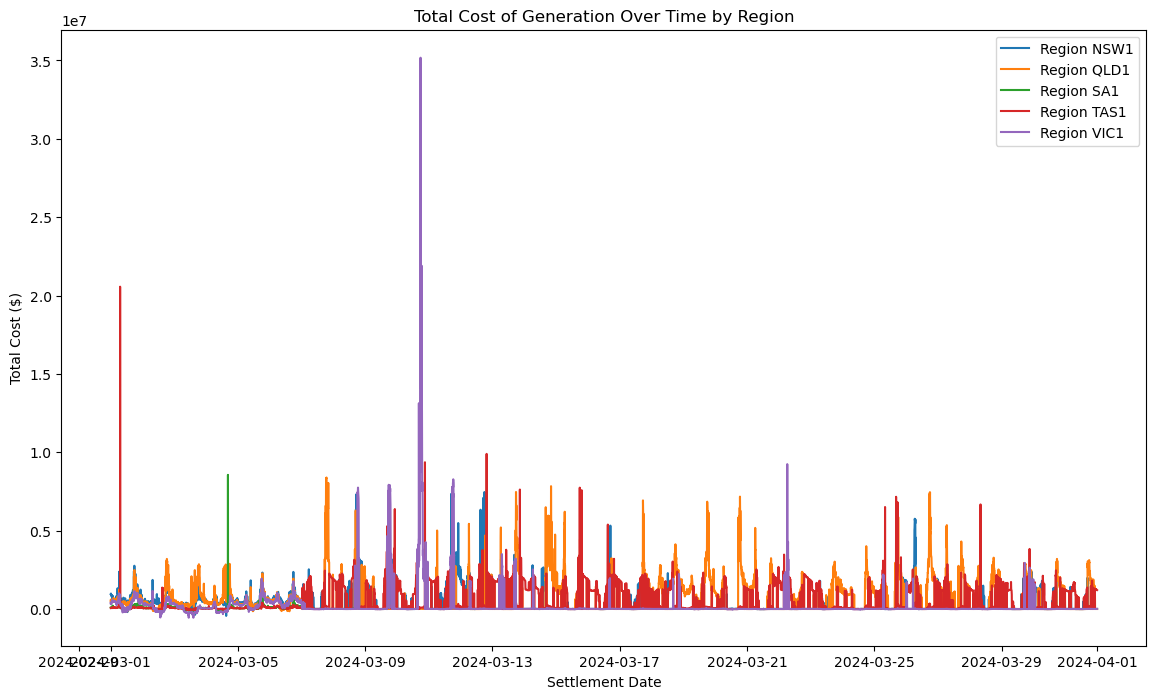

In [101]:
#Time Series Plot of Total Cost
plt.figure(figsize=(14, 8))
for region in results_df['REGIONID'].unique():
    region_data = results_df[results_df['REGIONID'] == region]
    plt.plot(region_data['SETTLEMENTDATE'], region_data['TotalCost'], label=f'Region {region}')
plt.xlabel('Settlement Date')
plt.ylabel('Total Cost ($)')
plt.title('Total Cost of Generation Over Time by Region')
plt.legend()

Text(0.5, 1.0, 'Renewable Generation by Region Over Time')

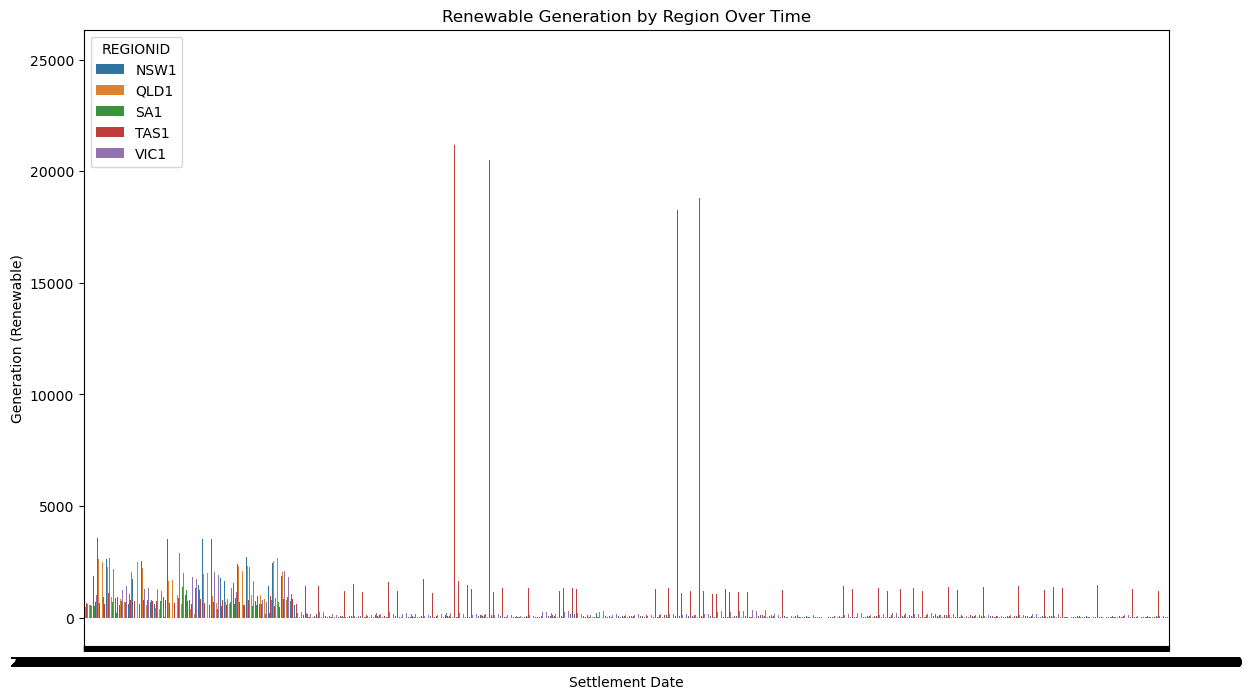

In [102]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='SETTLEMENTDATE', y='GenRenewable', hue='REGIONID')
plt.xlabel('Settlement Date')
plt.ylabel('Generation (Renewable)')
plt.title('Renewable Generation by Region Over Time')

Text(0.5, 1.0, 'Non-Renewable Generation by Region Over Time')

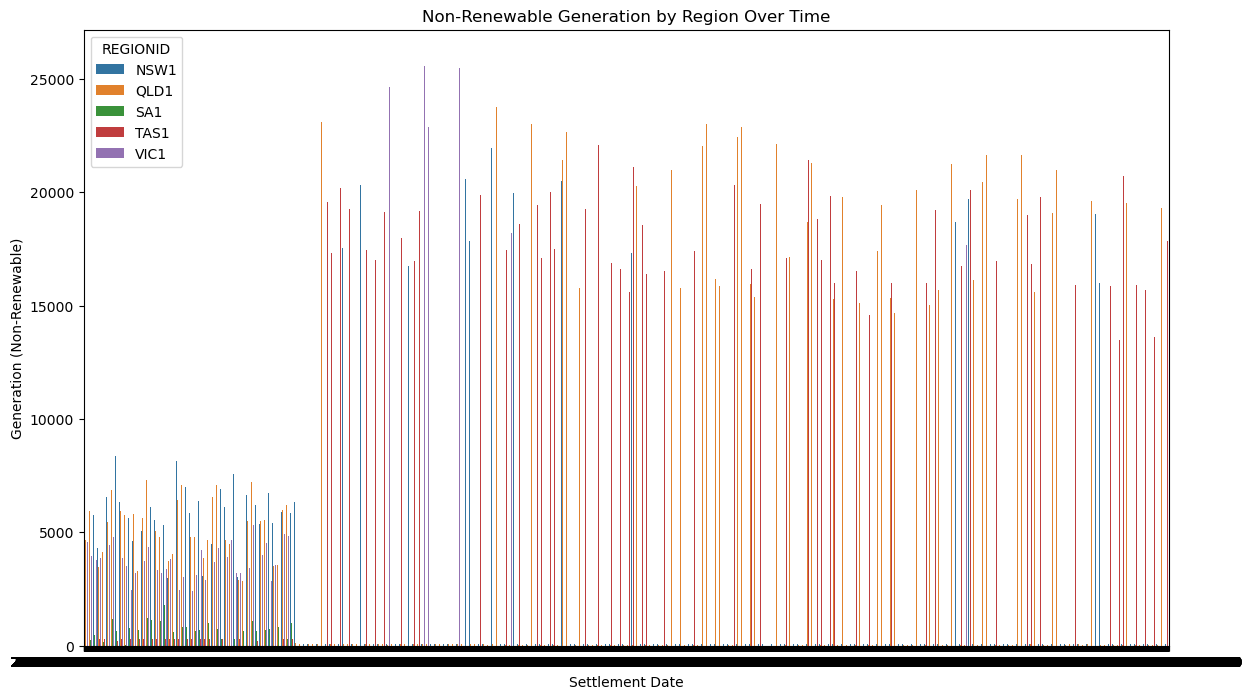

In [103]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='SETTLEMENTDATE', y='GenNonRenewable', hue='REGIONID')
plt.xlabel('Settlement Date')
plt.ylabel('Generation (Non-Renewable)')
plt.title('Non-Renewable Generation by Region Over Time')